<a href="https://colab.research.google.com/github/DSNortsev/CSE-694-Case-Studies-in-Deep-Learning/blob/master/Project/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Case Studies**
## **Project**
## **a. Model design**
________________________

### **Import all necessary python libraries**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


### **Phase 1: Data Preprocessing**
Read Train dataset and drop "row_ID" column

In [ ]:
# Read Train data set
df_train = pd.read_csv("Research_data_train.csv") 
# Exclude row_id from dataframe
df_train = df_train.loc[:, df_train.columns != 'row_ID']
# Display number of rows set to None to display all rows
pd.set_option('display.max_rows', 10)
df_train

,CaseID,Weeks,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,Factor21,Factor22,Factor23,Factor24,Factor25,Factor26,Factor27,Factor28,Factor29,Factor30,Factor31,Factor32,Factor33,Factor34,Factor35,Factor36,Factor37,Factor38,Factor39,Factor40,Factor41,Factor42,Factor43,Factor44,Factor45,Factor46,Factor47,Factor48,Factor49,Factor50,Factor51,Factor52,Factor53,Factor54,Factor55,Factor56,Factor57,Factor58,Factor59,Factor60,Factor61,Factor62,Factor63,Factor64,Factor65,Factor66,Factor67,Factor68,Factor69,Factor70,Factor71,Factor72,Factor73,output
0,29764,3.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,14.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.454545,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.515152,0.0,0.0,0.0
1,29764,3.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,14.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.272727,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.515152,0.0,0.0,0.0
2,29764,3.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,14.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.454545,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.515152,0.0,0.0,0.0
3,29764,3.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,14.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.272727,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.515152,0.0,0.0,0.0
4,29764,6.060606,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,14.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.272727,0.000000,1.30719,0.0,0.0,0.0,0.000000,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,3.030303,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33992,30043,21.212121,0.0,0.0,0.0,12.0,0.0,0.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.428571,2.857143,0.0,18.852459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,6.666667,50.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.000000,2.325581,0.00000,0.0,0.0,0.0,7.003891,0.854701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.151515,0.0,0.0,0.0,9.677419,0.0,9.090909,0.0,0.0,0.0
33993,30043,21.212121,0.0,0.0,0.0,12.0,0.0,0.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.428571,2.857143,0.0,18.852459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,6.666667,50.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.545455,2.325581,0.00000,0.0,0.0,0.0,7.003891,0.854701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.151515,0.0,0.0,0.0,9.677419,0.0,9.090909,0.0,0.0,0.0
33994,30043,21.212121,0.0,0.0,0.0,12.0,0.0,0.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.428571,2.857143,0.0,18.852459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,6.666667,50.0,0.0,0.000000,0.

Drop all rows with Nan value 

In [ ]:
df_train.isnull().sum()

CaseID      0
Weeks       0
Factor1     0
Factor2     0
Factor3     0
           ..
Factor70    1
Factor71    1
Factor72    1
Factor73    1
output      1
Length: 76, dtype: int64

In [ ]:
# Drop raws with NaN values
df_train = df_train.dropna()

Aggregate all rows by "CaseId" and "Weeks" with mean value.  Each case_id would have only one entry per week.

In [ ]:
# Group by CaseID and Week and flatten the tabel
df_train_aggregated = df_train.groupby(['CaseID', 'Weeks'], sort=False).mean().reset_index()
df_train_aggregated

,CaseID,Weeks,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,Factor21,Factor22,Factor23,Factor24,Factor25,Factor26,Factor27,Factor28,Factor29,Factor30,Factor31,Factor32,Factor33,Factor34,Factor35,Factor36,Factor37,Factor38,Factor39,Factor40,Factor41,Factor42,Factor43,Factor44,Factor45,Factor46,Factor47,Factor48,Factor49,Factor50,Factor51,Factor52,Factor53,Factor54,Factor55,Factor56,Factor57,Factor58,Factor59,Factor60,Factor61,Factor62,Factor63,Factor64,Factor65,Factor66,Factor67,Factor68,Factor69,Factor70,Factor71,Factor72,Factor73,output
0,29764,3.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,14.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.363636,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.515152,0.0,0.0,0.0
1,29764,6.060606,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,14.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.363636,0.000000,1.307190,0.0,0.0,0.000000,0.000000,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,3.030303,0.0,0.0,0.0
2,29764,9.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,14.285714,0.0,0.0,0.0,5.0,0.0,0.0,0.0,18.363636,0.000000,2.614379,0.0,0.0,0.000000,0.000000,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,4.545455,0.0,0.0,0.0
3,29764,12.121212,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.000000,0.0,0.000000,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,14.285714,0.0,0.0,0.0,5.0,0.0,0.0,0.0,18.363636,0.000000,3.921569,0.0,0.0,33.333333,0.000000,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,6.060606,0.0,0.0,0.0
4,29764,15.151515,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.000000,0.0,0.000000,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,14.285714,0.0,0.0,0.0,10.0,0.0,0.0,0.0,18.363636,0.000000,4.575163,0.0,0.0,33.333333,0.000000,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,7.575758,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,30043,12.121212,0.0,0.0,0.0,4.0,0.0,0.0,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.000000,0.0,9.836066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.272727,0.000000,0.000000,0.0,0.0,0.000000,3.112840,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.030303,0.0,0.0,0.0,9.677419,0.0,4.545455,0.0,0.0,0.0
8688,30043,15.151515,0.0,0.0,0.0,4.0,0.0,0.0,5.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.571429,0.000000,0.0,13.934426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.272727,0.000000,0.000000,0.0,0.0,0.000000,4.409857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.121212,0.0,0.0,0.0,9.677419,0.0,6.060606,0.0,0.0,0.0
8689,30043,18.181818,0.0,0.0,0.0,8.0,0.0,0.0,6.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.428571,0.571429,0.0,16.393443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.

Assign output feature to y and all other features to x variable.

In [ ]:
y = df_train_aggregated.output                      
x = df_train_aggregated.drop(['CaseID','Weeks','output'] ,axis = 1 )
print(y)
print(x)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8687    0.0
8688    0.0
8689    0.0
8690    0.0
8691    0.0
Name: output, Length: 8692, dtype: float64
      Factor1  Factor2  Factor3  ...   Factor71  Factor72  Factor73
0         0.0      0.0      0.0  ...   1.515152       0.0       0.0
1         0.0      0.0      0.0  ...   3.030303       0.0       0.0
2         0.0      0.0      0.0  ...   4.545455       0.0       0.0
3         0.0      0.0      0.0  ...   6.060606       0.0       0.0
4         0.0      0.0      0.0  ...   7.575758       0.0       0.0
...       ...      ...      ...  ...        ...       ...       ...
8687      0.0      0.0      0.0  ...   4.545455       0.0       0.0
8688      0.0      0.0      0.0  ...   6.060606       0.0       0.0
8689      0.0      0.0      0.0  ...   7.575758       0.0       0.0
8690      0.0      0.0      0.0  ...   9.090909       0.0       0.0
8691      0.0      0.0      0.0  ...  10.606061       0.0       0.0

[8692 ro

Plot total cases with positve and negative diagnosis.

Number of Benign:  7603
Number of Malignant :  1089


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


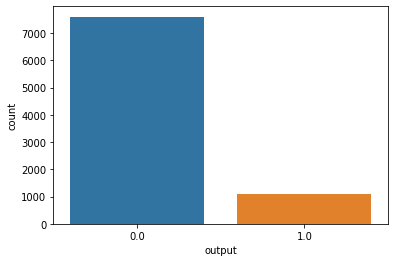

In [ ]:
# Display how many positive and negative cases
ax = sns.countplot(y,label="Count")      
negative, positive = y.value_counts()
print('Number of Benign: ', negative)
print('Number of Malignant : ', positive)

See the max value row and check if there is a variance. As we can see all values are between 0 and 100. That data can be normalized to represent a value between 0 and 1. 

In [ ]:
# See the max value and check if there is a veriance 
x.describe()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,Factor21,Factor22,Factor23,Factor24,Factor25,Factor26,Factor27,Factor28,Factor29,Factor30,Factor31,Factor32,Factor33,Factor34,Factor35,Factor36,Factor37,Factor38,Factor39,Factor40,Factor41,Factor42,Factor43,Factor44,Factor45,Factor46,Factor47,Factor48,Factor49,Factor50,Factor51,Factor52,Factor53,Factor54,Factor55,Factor56,Factor57,Factor58,Factor59,Factor60,Factor61,Factor62,Factor63,Factor64,Factor65,Factor66,Factor67,Factor68,Factor69,Factor70,Factor71,Factor72,Factor73
count,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000,8692.000000
mean,2.115188,1.803382,1.342670,7.142660,7.305568,2.131502,1.681546,0.276116,0.116732,2.631730,3.912340,4.344992,3.859871,0.867896,19.762343,5.647426,1.632696,1.377751,8.617119,2.026335,5.395766,0.921266,2.098993,2.576067,5.198441,7.913023,15.399218,1.175027,6.643598,55.568339,2.753764,8.053382,6.225392,6.865357,2.234814,6.837056,4.432237,3.231629,3.365547,13.253566,19.613298,4.524686,7.984353,3.105971,2.194866,11.609526,24.263691,1.480471,2.730480,40.954992,1.838633,2.893352,7.969233,1.608022,7.040957,5.581619,3.003744,5.833410,5.434883,2.219666,4.665209,7.029452,6.661298,2.252646,14.924208,2.624208,4.255254,4.427443,6.004780,1.197761,2.868189,4.715064,10.281485
std,7.995938,8.174785,6.413729,8.683673,13.027044,6.205751,6.476325,2.192715,2.455957,8.787673,13.256158,13.346529,13.345990,5.631262,16.303937,14.289697,7.526820,6.542841,14.715801,7.919155,16.061163,4.086696,6.484173,10.460450,16.277074,14.984141,25.010215,5.113913,10.830848,49.691827,9.287392,13.630322,13.282295,12.800313,8.876048,15.685314,11.743740,8.913438,8.066129,22.173854,22.114452,10.441639,18.442040,8.979076,7.988398,19.250968,25.458148,7.689362,13.213500,21.546776,6.685784,8.612730,18.957589,8.935490,14.586280,6.841896,8.861484,13.886793,13.113140,6.056301,11.882308,25.565743,13.528208,8.283141,17.495556,9.018559,11.707489,12.506307,13.766329,5.467430,10.159364,12.574761,16.307291
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

Let's plot correletaion matrix. From the graph below, we can see that column Factor5 and Factor32 are correlated. We can drop  Factor5 column.

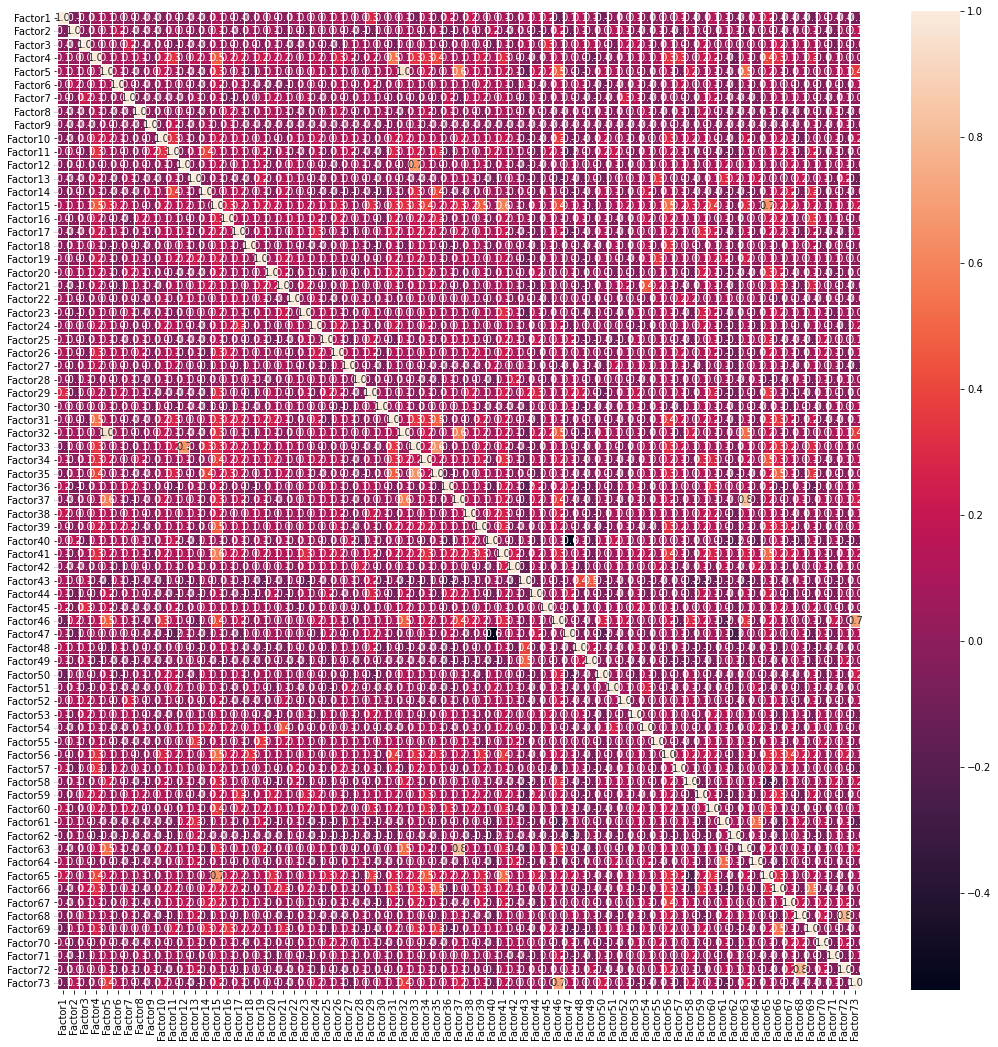

In [ ]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [ ]:
# Factor5 and Factor32 are correlated, dropping Factor2 feature
x_new = x.drop(['Factor5'],axis = 1 ) 
x_new

,Factor1,Factor2,Factor3,Factor4,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,Factor21,Factor22,Factor23,Factor24,Factor25,Factor26,Factor27,Factor28,Factor29,Factor30,Factor31,Factor32,Factor33,Factor34,Factor35,Factor36,Factor37,Factor38,Factor39,Factor40,Factor41,Factor42,Factor43,Factor44,Factor45,Factor46,Factor47,Factor48,Factor49,Factor50,Factor51,Factor52,Factor53,Factor54,Factor55,Factor56,Factor57,Factor58,Factor59,Factor60,Factor61,Factor62,Factor63,Factor64,Factor65,Factor66,Factor67,Factor68,Factor69,Factor70,Factor71,Factor72,Factor73
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,14.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.363636,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.515152,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,14.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.363636,0.000000,1.307190,0.0,0.0,0.000000,0.000000,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,3.030303,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,14.285714,0.0,0.0,0.0,5.0,0.0,0.0,0.0,18.363636,0.000000,2.614379,0.0,0.0,0.000000,0.000000,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,4.545455,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.000000,0.0,0.000000,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,14.285714,0.0,0.0,0.0,5.0,0.0,0.0,0.0,18.363636,0.000000,3.921569,0.0,0.0,33.333333,0.000000,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,6.060606,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.000000,0.0,0.000000,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,14.285714,0.0,0.0,0.0,10.0,0.0,0.0,0.0,18.363636,0.000000,4.575163,0.0,0.0,33.333333,0.000000,0.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,7.575758,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,0.0,0.0,0.0,4.0,0.0,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.857143,0.000000,0.0,9.836066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.272727,0.000000,0.000000,0.0,0.0,0.000000,3.112840,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.030303,0.0,0.0,0.0,9.677419,0.0,4.545455,0.0,0.0
8688,0.0,0.0,0.0,4.0,0.0,5.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.571429,0.000000,0.0,13.934426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,0.000000,50.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.272727,0.000000,0.000000,0.0,0.0,0.000000,4.409857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.121212,0.0,0.0,0.0,9.677419,0.0,6.060606,0.0,0.0
8689,0.0,0.0,0.0,8.0,0.0,6.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.428571,0.571429,0.0,16.393443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.941748,6.666667,50.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.272727,2.325581,0.000000,0.0,0.0,0.000000,5.706874,0.854701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.151515,0.0,0.0,0.0,9.677419,0.0,7.575758,0.0,0.0
8690,0.0,0.0,0.0

### **Step 2: Create training and testing datasets¶**

In [ ]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(f'X_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'X_test : {x_test.shape}, y_test : {y_test.shape}')

X_train: (6084, 72), y_train: (6084,)
X_test : (2608, 72), y_test : (2608,)


### **Step 3: Normalize the feature data, all values should be in a range from 0 to 1**


In [ ]:
# Normalize X features, make all values between 0 and 1
x_train = pd.DataFrame(preprocessing.normalize(x_train),
                               columns=x_train.columns,
                               index=x_train.index)
x_test = pd.DataFrame(preprocessing.normalize(x_test),
                           columns=x_test.columns,
                           index=x_test.index)
x_train

,Factor1,Factor2,Factor3,Factor4,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,Factor21,Factor22,Factor23,Factor24,Factor25,Factor26,Factor27,Factor28,Factor29,Factor30,Factor31,Factor32,Factor33,Factor34,Factor35,Factor36,Factor37,Factor38,Factor39,Factor40,Factor41,Factor42,Factor43,Factor44,Factor45,Factor46,Factor47,Factor48,Factor49,Factor50,Factor51,Factor52,Factor53,Factor54,Factor55,Factor56,Factor57,Factor58,Factor59,Factor60,Factor61,Factor62,Factor63,Factor64,Factor65,Factor66,Factor67,Factor68,Factor69,Factor70,Factor71,Factor72,Factor73
7756,0.0,0.0,0.0,0.034718,0.009976,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.247983,0.000000,0.0,0.0,0.000000,0.000000,0.433970,0.005106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.341915,0.123991,0.000000,0.050315,0.000000,0.000000,0.433970,0.0,0.0,0.497093,0.000000,0.000000,0.0,0.000000,0.289313,0.105819,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.289313,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000
1795,0.0,0.0,0.0,0.053449,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209979,0.194708,0.0,0.0,0.167029,0.000000,0.334057,0.000000,0.074235,0.255456,0.000000,0.133623,0.334057,0.000000,0.102787,0.000000,0.047722,0.133623,0.0,0.351639,0.0,0.000000,0.000000,0.000000,0.0,0.334057,0.263197,0.095445,0.000000,0.000000,0.087732,0.000000,0.000000,0.0,0.0,0.244570,0.000000,0.000000,0.0,0.051393,0.000000,0.027730,0.045683,0.000000,0.133623,0.133623,0.0000,0.0,0.167029,0.0,0.202459,0.154180,0.00000,0.0,0.172417,0.000000,0.0,0.0,0.000000
1702,0.0,0.0,0.0,0.052851,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.226506,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.073405,0.000000,0.000000,0.000000,0.000000,0.000000,0.010164,0.000000,0.000000,0.264257,0.0,0.278165,0.0,0.000000,0.330321,0.025656,0.0,0.000000,0.280272,0.000000,0.000000,0.201065,0.000000,0.297289,0.330321,0.0,0.0,0.374764,0.000000,0.000000,0.0,0.000000,0.000000,0.034275,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.330321,0.0,0.260253,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.220214
3460,0.0,0.0,0.0,0.066848,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.429737,0.000000,0.0,0.0,0.208900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.102843,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.411372,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.060551,0.000000,0.000000,0.417800,0.0,0.0,0.472494,0.019433,0.000000,0.0,0.000000,0.278533,0.158233,0.000000,0.033424,0.000000,0.000000,0.2089,0.0,0.000000,0.0,0.101285,0.000000,0.16712,0.0,0.000000,0.000000,0.0,0.0,0.000000
5254,0.0,0.0,0.0,0.046282,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033058,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175310,0.462818,0.000000,0.000000,0.089003,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.140248,0.000000,0.578522,0.016769,0.000000,0.000000,0.578522,0.0,0.0,0.208268,0.000000,0.000000,0.0,0.000000,0.000000,0.012006,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.105186,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0,0.0,0.0,0.037219,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.930464,0.066462,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.028196,0.132923,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.331583,0.000000,0.000000,0.0,0.000000,

Accuracy is:  0.9846625766871165


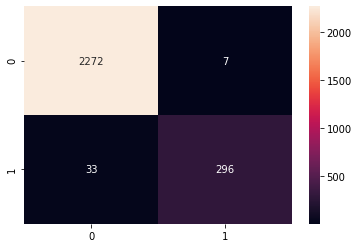

In [ ]:
#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

### **Univariate feature selection and random forest classification¶**
In univariate feature selection, we will use SelectKBest that removes all but the k highest scoring features. 

In this method we need to choose how many features we will use. For example, will k (number of features) be 5 or 10 or 15? In our case, we will be using 20 highest scoring features

In [ ]:
# find best scored 20 features
select_feature = SelectKBest(chi2, k=20).fit(x_train, y_train)
print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)
# Extract column
# cols = select_feature.get_support(indices=True)
# features_df_new = x_1.iloc[:,cols]
# print(x_train.iloc[:,[68]])

Score list: [8.20125778e-04 5.08734487e+00 1.29066157e+01 1.80950717e+00
 4.08517256e+00 6.15694398e-02 1.82809427e-01 1.12339705e+00
 5.44289320e-03 3.07974312e-01 4.88407372e+00 1.98731196e+01
 4.62749715e-01 1.85682745e+00 1.42798101e+01 6.01300099e+00
 9.54064547e+00 3.00561913e+00 8.06062567e-01 1.75838489e-01
 1.00483550e-01 8.38675211e-01 1.09438874e+01 1.48906383e+00
 1.33823182e+00 5.94761599e-02 9.54062087e-02 2.37767704e-01
 5.06963897e-04 2.17878783e+00 1.41363334e+00 1.25944663e+00
 3.26713198e+00 1.96609900e-01 6.68659689e-03 6.01469455e+00
 2.05092207e-01 1.91425455e-02 6.30546728e+00 2.50112748e+00
 3.51175432e-02 9.32137353e-01 2.54533796e+00 1.46479925e+01
 8.76510346e-03 1.22797450e+00 1.00087869e+00 3.29075966e-01
 4.59352930e+00 1.56498035e+00 2.07156054e-01 1.97141499e+00
 3.11338411e-01 1.59286952e+01 8.68166988e-01 1.24831761e-01
 3.01934457e+00 3.89903290e-01 3.06111350e+00 6.24084400e-01
 1.04094447e+00 1.07755737e+00 3.63327506e-01 4.38488528e-02
 2.06233134e

In [ ]:
# Extract the name of highest scoring features
cols = select_feature.get_support(indices=True)
features = x_new.iloc[:,cols].columns
features

Index(['Factor2', 'Factor3', 'Factor6', 'Factor12', 'Factor13', 'Factor16',
       'Factor17', 'Factor18', 'Factor19', 'Factor24', 'Factor34', 'Factor37',
       'Factor40', 'Factor45', 'Factor50', 'Factor55', 'Factor58', 'Factor60',
       'Factor66', 'Factor69'],
      dtype='object')

Select the most important features and run RandomForestClassifier to verify if dimensionality reduction affects the accuracy percentage. 

[[0.         0.         0.00997631 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.13362291 0.15418028 0.17241665]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.03090572 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01956451 ... 0.         0.01636646 0.05490684]]
Accuracy is:  0.9739263803680982


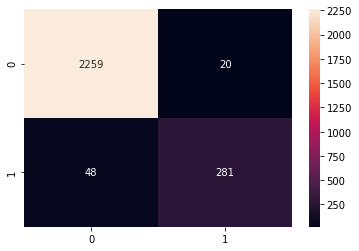

In [ ]:
x_train_2 = select_feature.transform(x_train)
x_test_2 = select_feature.transform(x_test)
print(x_train_2)
#random forest classifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)
ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
print('Accuracy is: ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(x_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")

### **Phase 2: Model Building**
#### **Step 1: Build model¶**

&nbsp;&nbsp;&nbsp;&nbsp;The **tf.keras.Sequential** model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, one tf.keras.layers.Dense layer with 20 nodes, two layers with 20 and 10 nodes, and an output layer with 1 nodes representing our label predictions. The first layer’s input_shape parameter corresponds to the number of features from the dataset which is equal 20.<br> 
&nbsp;&nbsp;&nbsp;&nbsp;The activation function determines the output shape of each node in the layer. These non linearities are important, without them the model would be equivalent to a single layer. There are many tf.keras.activations such as tanh, like sigmoid or relu. In our two models we have decided to use "sigmoid" and "relu" and compare the performance.<br>
&nbsp;&nbsp;&nbsp;&nbsp;The ideal number of hidden layers and neurons depends on the problem and the dataset. Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively. For our illustration we have used a models with 2 layers. Our expectation that the model with many layers should give a better result.<br>


In [ ]:
def model_with_2_layers():
  model = Sequential()
  model.add(Dense(20, input_dim=20, activation='relu', name='input_layer'))
  model.add(Dense(10, activation='relu', name='layer_1'))
  model.add(Dense(1, activation='sigmoid', name='output_layer'))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

#### **Step 2: Create estimator and evaluate the model with k-Fold Cross Validation**
&nbsp;&nbsp;&nbsp;&nbsp;We can also pass arguments in the construction of the KerasClassifier class that will be passed on to the fit() function internally used to train the neural network. Here, we pass the number of epochs as 70 and batch size as 20 to use when training the model.<br>
&nbsp;&nbsp;&nbsp;&nbsp;Now, the neural network model can be evaluated on a training dataset. The scikit-learn has excellent capability to evaluate models using a suite of techniques. The gold standard for evaluating machine learning models is k-fold cross validation.Since the dataset is quite small, we can pass 5 fold for cross validation.<br>


In [ ]:
seed = 42

# Suppress Tensorflow warning
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

estimator = KerasClassifier(
        build_fn=model_with_2_layers,
        epochs=70, batch_size=20,
        verbose=0)

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x_train_2, y_train, cv=kfold)
print(f'Model Performance:\nmean: {results.mean()*100:.2f}\
        \nstd: {results.std()*100:.2f}')

Model Performance:
mean: 96.61        
std: 0.33


## **b. Training results**
______________________

#### **Phase 3 : Fit the model**


In [ ]:
md1 = model_with_2_layers()
md1.fit(x_train_2,
       y_train,
       epochs=70,
       shuffle=True, # shuffle data randomly.
       verbose=0 # this will tell keras to print more detailed info
       )

# Validate the model with test dateset
test_error_rate = md1.evaluate(x_test_2, y_test, verbose=0)
print(f'{md1.metrics_names[1]}: {test_error_rate[1]*100:.2f}')
print(f'{md1.metrics_names[0]}: {test_error_rate[0]*100:.2f}')

accuracy: 97.01
loss: 10.45


### STEP 4: Evaluate model performs on the test data

In [ ]:
y_test.value_counts()

0.0    2279
1.0     329
Name: output, dtype: int64


EVALUATION OF THE DNN MODEL ON TEST DATA SET: 




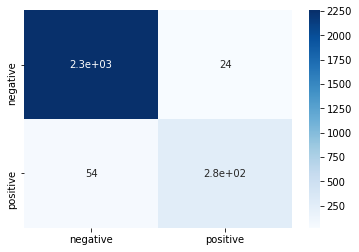

In [ ]:
from sklearn.metrics import confusion_matrix


def evaluate_performace(actual, expected):
    """
    Function accepts two lists with actual and expected lables
    """
    diagnosis = {0:'negative',
               1:'positive'}
    print(f'Diagnosis in test set: \nNegative={y_test.value_counts()[0]}\
          \nPositive={y_test.value_counts()[0]}')
    
    for act,exp in zip(actual, expected):
        if int(act) != int(exp):
            print(f'ERROR: {diagnosis[exp]} predicted as {diagnosis[act]}')

print(f'\nEVALUATION OF THE DNN MODEL ON TEST DATA SET: ')
predicted_targets = md1.predict_classes(x_test_2).flatten()
true_targets = y_test.to_numpy()
# evaluate_performace(predicted_targets, true_targets)
# target_names=['negative', 'positive']

fig, ax =plt.subplots(1,1)
conf_matrix = confusion_matrix(true_targets, predicted_targets)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=target_names,yticklabels=target_names)
print('\n')

## **c. Output of the test file with an extra column for prediction.**
_____________

Read Test dataset and drop "row_ID" column

In [ ]:
# Read Train data set
df_test = pd.read_csv("Research_data_test.csv") 
# Exclude row_id from dataframe
df_test = df_test.loc[:, df_test.columns != 'row_ID']
df_test

,CaseID,Weeks,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,Factor21,Factor22,Factor23,Factor24,Factor25,Factor26,Factor27,Factor28,Factor29,Factor30,Factor31,Factor32,Factor33,Factor34,Factor35,Factor36,Factor37,Factor38,Factor39,Factor40,Factor41,Factor42,Factor43,Factor44,Factor45,Factor46,Factor47,Factor48,Factor49,Factor50,Factor51,Factor52,Factor53,Factor54,Factor55,Factor56,Factor57,Factor58,Factor59,Factor60,Factor61,Factor62,Factor63,Factor64,Factor65,Factor66,Factor67,Factor68,Factor69,Factor70,Factor71,Factor72,Factor73
0,9011,36.363636,0.000000,0.00000,0.000000,4.0,10.0,0.000000,0.0,0.000000,0.000000,7.81250,0.000000,0.000000,0.0,0.0,2.857143,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,16.666667,0.0,0.0,0.0,0.000000,100.0,0.000000,10.0,0.000000,0.000000,0.00,0.000000,12.50,0.970874,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,12.50,25.0,0.0,0.000000,56.363636,0.000000,0.000000,0.000000,0.0,0.000000,2.853437,0.000000,8.0,0.0,0.000000,0.00,0.0,12.50,0.0,0.000000,0.000000,0.000000,8.333333,0.000000,0.000000,0.000000,8.333333,16.666667
1,31309,24.242424,0.000000,5.46875,0.000000,3.0,0.0,0.000000,0.0,0.000000,7.317073,0.00000,6.060606,0.000000,0.0,0.0,3.571429,6.000000,0.0,1.229508,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,100.0,1.785714,0.0,5.555556,2.631579,6.25,0.000000,0.00,0.485437,3.333333,12.5,5.303030,3.571429,12.5,1.086957,0.000000,0.00,0.0,0.0,0.000000,42.545455,0.000000,0.000000,0.714286,0.0,0.000000,1.102464,0.000000,0.0,0.0,0.000000,12.50,0.0,0.00,0.0,3.030303,2.884615,0.000000,0.000000,3.225806,0.000000,0.000000,0.000000,0.000000
2,12239,18.181818,0.000000,0.00000,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,2.142857,0.000000,0.0,0.000000,6.25,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.315789,0.00,0.000000,0.00,0.000000,0.000000,0.0,3.030303,0.000000,0.0,2.536232,0.000000,0.00,25.0,0.0,0.000000,45.090909,0.000000,0.000000,0.000000,0.0,0.000000,0.389105,0.000000,1.0,0.0,0.000000,6.25,0.0,0.00,5.0,0.757576,0.000000,3.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,40114,21.212121,0.000000,0.00000,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.78125,0.000000,0.000000,0.0,0.0,3.571429,0.000000,0.0,0.000000,6.25,0.806452,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.785714,0.0,0.000000,5.263158,0.00,0.000000,0.00,0.485437,0.000000,0.0,3.787879,3.571429,0.0,0.000000,0.000000,1.25,0.0,0.0,0.000000,42.545455,0.581395,1.307190,0.000000,0.0,0.000000,0.194553,0.000000,0.0,0.0,0.000000,0.00,0.0,6.25,0.0,2.272727,0.000000,0.000000,0.000000,0.000000,2.734375,0.000000,0.000000,8.333333
4,33356,48.484848,0.000000,0.00000,0.000000,4.0,5.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,8.333333,0.0,0.0,10.714286,6.142857,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,5.0,12.5,0.0,1.923077,100.0,1.785714,5.0,16.666667,7.894737,6.25,0.000000,6.25,1.456311,0.000000,0.0,0.000000,0.000000,0.0,2.898551,0.000000,8.75,12.5,0.0,0.000000,57.090909,0.000000,0.000000,0.000000,0.0,8.333333,1.750973,0.000000,0.0,5.0,0.000000,0.00,0.0,6.25,0.0,0.000000,0.000000,0.000000,0.000000,2.419355,0.000000,0.000000,0.000000,8.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25743,6268,21.212121,0.000000,0.00000,0.000000,2.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,1.428571,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,10.0,0.0,0.0,3.846154,100.0,0.000000,0.0,0.000000,0.000000,0.00,4.615385,0.00,2.912621,0.000000,25.0,6.060606,7.142857,0.0,0.000000,3.030303,0.

In [ ]:
# Check for missing values
df_test.isnull().sum()

CaseID      0
Weeks       0
Factor1     0
Factor2     0
Factor3     0
           ..
Factor69    0
Factor70    0
Factor71    0
Factor72    0
Factor73    0
Length: 75, dtype: int64

In [ ]:
# Select 20 features with the highest score
df_test_reduced = df_test[features]
df_test_reduced

,Factor2,Factor3,Factor6,Factor12,Factor13,Factor16,Factor17,Factor18,Factor19,Factor24,Factor34,Factor37,Factor40,Factor45,Factor50,Factor55,Factor58,Factor60,Factor66,Factor69
0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.000000,12.50,0.0,0.000000,56.363636,0.000000,8.0,0.000000,0.000000,0.000000
1,5.46875,0.000000,0.000000,0.000000,0.0,6.000000,0.0,1.229508,0.00,0.0,2.631579,0.00,12.5,0.000000,42.545455,0.000000,0.0,0.000000,2.884615,3.225806
2,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,6.25,0.0,1.315789,0.00,0.0,0.000000,45.090909,0.000000,1.0,0.000000,0.000000,0.000000
3,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,6.25,0.0,5.263158,0.00,0.0,0.000000,42.545455,0.000000,0.0,0.000000,0.000000,0.000000
4,0.00000,0.000000,0.000000,8.333333,0.0,6.142857,0.0,0.000000,0.00,0.0,7.894737,6.25,0.0,0.000000,57.090909,8.333333,0.0,0.000000,0.000000,2.419355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25743,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,25.0,3.030303,37.818182,0.000000,0.0,0.000000,0.000000,0.000000
25744,0.00000,0.000000,0.000000,0.000000,0.0,2.571429,0.0,0.000000,0.00,0.0,0.000000,0.00,0.0,0.000000,39.272727,0.000000,0.0,1.666667,0.000000,3.225806
25745,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.0,0.000000,56.363636,0.000000,4.0,0.000000,0.000000,0.000000
25746,0.00000,2.459016,2.873563,0.000000,0.0,3.285714,0.0,0.000000,0.00,0.0,0.000000,0.00,0.0,1.515152,40.727273,0.000000,0.0,0.000000,0.000000,0.000000


In [ ]:
# Normalize X features, make all values between 0 and 1

x_predict = pd.DataFrame(preprocessing.normalize(df_test_reduced),
                           columns=df_test_reduced.columns,
                           index=df_test_reduced.index).to_numpy()
print(x_predict)


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.12050744 0.         0.         ... 0.         0.06356436 0.07108273]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.05988512 0.0699807  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
# Predict outoput values based on test features
predicted_output = md1.predict_classes(x_predict)
unique, counts = np.unique(predicted_output, return_counts=True)
# Print total count for Negative - 0 and Postives - 1 values
dict(zip(unique, counts))

{0: 21560, 1: 4188}

In [ ]:
# Append predicted result to pandas DataFrame
df_test['output'] = predicted_output
df_test

,CaseID,Weeks,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,Factor21,Factor22,Factor23,Factor24,Factor25,Factor26,Factor27,Factor28,Factor29,Factor30,Factor31,Factor32,Factor33,Factor34,Factor35,Factor36,Factor37,Factor38,Factor39,Factor40,Factor41,Factor42,Factor43,Factor44,Factor45,Factor46,Factor47,Factor48,Factor49,Factor50,Factor51,Factor52,Factor53,Factor54,Factor55,Factor56,Factor57,Factor58,Factor59,Factor60,Factor61,Factor62,Factor63,Factor64,Factor65,Factor66,Factor67,Factor68,Factor69,Factor70,Factor71,Factor72,Factor73,output
0,9011,36.363636,0.000000,0.00000,0.000000,4.0,10.0,0.000000,0.0,0.000000,0.000000,7.81250,0.000000,0.000000,0.0,0.0,2.857143,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,16.666667,0.0,0.0,0.0,0.000000,100.0,0.000000,10.0,0.000000,0.000000,0.00,0.000000,12.50,0.970874,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,12.50,25.0,0.0,0.000000,56.363636,0.000000,0.000000,0.000000,0.0,0.000000,2.853437,0.000000,8.0,0.0,0.000000,0.00,0.0,12.50,0.0,0.000000,0.000000,0.000000,8.333333,0.000000,0.000000,0.000000,8.333333,16.666667,0
1,31309,24.242424,0.000000,5.46875,0.000000,3.0,0.0,0.000000,0.0,0.000000,7.317073,0.00000,6.060606,0.000000,0.0,0.0,3.571429,6.000000,0.0,1.229508,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,100.0,1.785714,0.0,5.555556,2.631579,6.25,0.000000,0.00,0.485437,3.333333,12.5,5.303030,3.571429,12.5,1.086957,0.000000,0.00,0.0,0.0,0.000000,42.545455,0.000000,0.000000,0.714286,0.0,0.000000,1.102464,0.000000,0.0,0.0,0.000000,12.50,0.0,0.00,0.0,3.030303,2.884615,0.000000,0.000000,3.225806,0.000000,0.000000,0.000000,0.000000,0
2,12239,18.181818,0.000000,0.00000,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,2.142857,0.000000,0.0,0.000000,6.25,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.315789,0.00,0.000000,0.00,0.000000,0.000000,0.0,3.030303,0.000000,0.0,2.536232,0.000000,0.00,25.0,0.0,0.000000,45.090909,0.000000,0.000000,0.000000,0.0,0.000000,0.389105,0.000000,1.0,0.0,0.000000,6.25,0.0,0.00,5.0,0.757576,0.000000,3.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,40114,21.212121,0.000000,0.00000,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.78125,0.000000,0.000000,0.0,0.0,3.571429,0.000000,0.0,0.000000,6.25,0.806452,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.785714,0.0,0.000000,5.263158,0.00,0.000000,0.00,0.485437,0.000000,0.0,3.787879,3.571429,0.0,0.000000,0.000000,1.25,0.0,0.0,0.000000,42.545455,0.581395,1.307190,0.000000,0.0,0.000000,0.194553,0.000000,0.0,0.0,0.000000,0.00,0.0,6.25,0.0,2.272727,0.000000,0.000000,0.000000,0.000000,2.734375,0.000000,0.000000,8.333333,0
4,33356,48.484848,0.000000,0.00000,0.000000,4.0,5.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,8.333333,0.0,0.0,10.714286,6.142857,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,5.0,12.5,0.0,1.923077,100.0,1.785714,5.0,16.666667,7.894737,6.25,0.000000,6.25,1.456311,0.000000,0.0,0.000000,0.000000,0.0,2.898551,0.000000,8.75,12.5,0.0,0.000000,57.090909,0.000000,0.000000,0.000000,0.0,8.333333,1.750973,0.000000,0.0,5.0,0.000000,0.00,0.0,6.25,0.0,0.000000,0.000000,0.000000,0.000000,2.419355,0.000000,0.000000,0.000000,8.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25743,6268,21.212121,0.000000,0.00000,0.000000,2.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,1.428571,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,10.0,0.0,0.0,3.846154,100.0,0.000000,0.0,0.000000,0.000000,0.00,4.615385,0.00,2.912621,0.000000,25.0,6.060606,7.142857,0.0

In [ ]:
# Create final csv file
df_test.to_csv("final_result.csv", index=False)

In [ ]:
# Copy csv file to Google drive
from google.colab import drive
drive.mount('/content/drive')
!cp final_result.csv drive/My\ Drive/Colab\ Notebooks/final_result.csv

Mounted at /content/drive
